# Speedtest Results Alanysis

This notebook organises, compares and visualises the results from different systems, on which the `GPU_CPU_Speedtest.ipynb` notebook was executed.
<br>
Please follow the instructions below to add your system speed test results to the mix.
<br>
<br>
Please note, you don't need to modify anything in your code to plot your system next to mine. This notebook supports plotting of 2 or 3 systems, depending on your specifications inside the `systems` variable (cell #1).

## Initial Setup

1. Create a directory for your personal computer system right next to my "LEGION" and "ROG" folders.
2. Paste your CSV speedtest results into the new directory. Make sure that the file names are a perfect match to:
   - `cpu_results.csv`
   - `gpu_results.csv`
4. In the code cell below, add your system as a new item in `systems`.
   <br>For example:<br>
`systems = ["LEGION", "ROG", "NEW_ITEM"]`
5. Run the notebook!

## Load Result Data from Local Files
First, we will load the information from the root directories specified in `systems`.
<br>
The data is split between different systems and devices.

In [1]:
import pandas as pd

systems = ["LEGION", "ROG"]
devices = ["CPU", "GPU"]

results = {}

for sys in systems:
    device_results = {}
    for dev in devices:
        device_results[dev] = pd.read_csv(sys + "/" + dev.lower() + "_results.csv")
        device_results[dev]["system"] = sys
        device_results[dev]["device"] = dev
        
    results[sys] = device_results

results["LEGION"]["CPU"].head()

,Unnamed: 0,n_estimators,max_features,random_state,n_features,accuracy,time,system,device
0,0,100.0,sqrt,8.0,1540.0,0.956378,69.618245,LEGION,CPU
1,1,100.0,sqrt,8.0,54.0,0.953796,18.689648,LEGION,CPU
2,2,100.0,1.0,8.0,1540.0,0.967006,732.822737,LEGION,CPU
3,3,100.0,1.0,8.0,54.0,0.968219,31.872830,LEGION,CPU
4,4,250.0,sqrt,8.0,1540.0,0.957092,80.407688,LEGION,CPU


## Unify Results Data
Unify the split data into a single DataFrame. Each system should take up 24 rows (unless you modified `GPU_CPU_Speedtest.ipynb` on your end).
<br>
The DataFrame `unified_results` produced in the following cell will be used for plotting throughout the notebook.

In [2]:
res = {}

count = 0
for sys in systems:    
    for dev in devices:
        res[count] = results[sys][dev]
        count += 1
        
unified_results = pd.concat(
    [res[i] for i in range(count)],
    ignore_index=True,
    axis=0,
)

print("systems:", set(unified_results["system"]))
print("rows:", unified_results.shape[0])
print("cols:", unified_results.shape[1])

systems: {'LEGION', 'ROG'}
rows: 48
cols: 9


## Filter Results

If you'd like to fetch specific information from the unified dataframe, please use the following syntax:

In [3]:
unified_results[
(unified_results['n_estimators'] == 500) &
(unified_results['n_features'] == 1540) &
(unified_results['max_features'] == "1.0") &
(unified_results['system'] == "ROG")
]

,Unnamed: 0,n_estimators,max_features,random_state,n_features,accuracy,time,system,device
34,10,500.0,1.0,8.0,1540.0,0.967712,4581.994421,ROG,CPU
46,10,500.0,1.0,8.0,1540.0,0.890304,226.814192,ROG,GPU


## Visualisation Functions
The following cell contains 2 visualisation functions that compare devices and systems.
<br>
Both functions focus on combinations of pairs of features from the following list:
<br>
`['max_features', 'n_estimators', 'n_features']`
<br>
<br>
Please choose 2 features and pass them as arguments to each function.

In [12]:
import matplotlib.pyplot as plt

def plot_runtime_by_system(
    data, 
    features=['max_features', 'n_estimators'], 
    colors=['orange', 'blue', 'magenta']
):
    """
    compare the performance of GPU and CPU on distinct systems
    (works for 2 or 3 systems with no code adjustments)
    """
    df = data
    # combine selected features
    df['features'] = df[features[0]].astype(str) + ', ' + df[features[1]].astype(str)
    
    # create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

    # assign device to subplot
    for dev, a in zip(["GPU", "CPU"], [ax1, ax2]):
        # plot device specific data
        dev_df = df[df['device'] == dev]
        pivot = dev_df.pivot_table(values='time', index='features', columns='system', aggfunc='mean')
        pivot.plot(kind='bar', ax=a, width=0.45, color=colors, legend=False)
        # set plot parameters
        a.set_xlabel('('+ features[0] + ', ' + features[1] + ')', fontsize=12)
        a.set_ylabel('Time (seconds)', fontsize=12)
        a.tick_params(axis='x', rotation=45)
        a.autoscale()
        a.grid(True, axis='y')
        # set legend
        handles, labels = a.get_legend_handles_labels()
        a.legend(
            handles, 
            labels, 
            title='System, Avg Time', 
            bbox_to_anchor=(0.7, 0.9), 
            loc='center left'
        )

    # set axis-specific parameters
    ax1.set_title('GPU: Runtime by System', fontsize=15, fontweight='bold', pad=20)
    ax2.set_title('CPU: Runtime by System', fontsize=15, fontweight='bold', pad=20)
    
    # set layout parameters
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.subplots_adjust(right=0.85, wspace=0.2)

    # plot figure
    plt.show()

def plot_runtime_by_device(
    data, 
    features=['max_features', 'n_estimators'], 
    colors=['blue', 'orange', 'magenta', 'purple', 'cyan', 'green']
):
    """
    compare the performance of a pair of features over distinct systems 
    (works for 2 or 3 systems with no code adjustments)
    """
    df = data

    # combine combo features
    df['features'] = df[features[0]].astype(str) + ', ' + df[features[1]].astype(str)
    
    # determine number of systems and create subplots
    systems = list(set(df['system']))
    num_systems = len(systems)
    fig, axes = plt.subplots(1, num_systems, figsize=(6 * num_systems, 6), sharey=True)
    
    # plot for each system
    for sys, ax in zip(systems, axes):
        # plot device-specific data
        sys_df = df[df['system'] == sys]
        pivot = sys_df.pivot_table(values='time', index='device', columns='features', aggfunc='mean')
        pivot.plot(kind='bar', ax=ax, width=0.6, color=colors, legend=False)
        # plot settings
        ax.set_ylabel('Time (seconds)', fontsize=12)
        ax.tick_params(axis='x', rotation=0)
        ax.autoscale()
        ax.grid(True, axis='y')
        # legend settings
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            handles, 
            labels, 
            title='('+ features[0] + ', ' + features[1] + ')', 
            bbox_to_anchor=(0.45, 0.83), 
            loc='center left'
        )
        # axis-specific settings
        ax.set_title(f'{sys}: Runtime by Device', fontsize=15, fontweight='bold', pad=20)
        ax.set_xlabel(f'{sys} Device', fontsize=12)

    # layout settings
    plt.tight_layout()
    plt.subplots_adjust(right=0.85, wspace=0.2)
    
    plt.show()

## Plot Runtime By System
The following visualization will compare the same device and feature combination across different systems.
<br>
The function will plot 1 additional system automatically, right beside LEGION and ROG. 
<br>
To plot more than 3 systems, you'd need to modify the code.
<br>
<br>
Additionally, please feel free to pass a different feature combination into the function, for example:
<br>
```
plot_runtime_by_system(
    unified_results, 
    ['n_features', 'n_estimators']
)
```

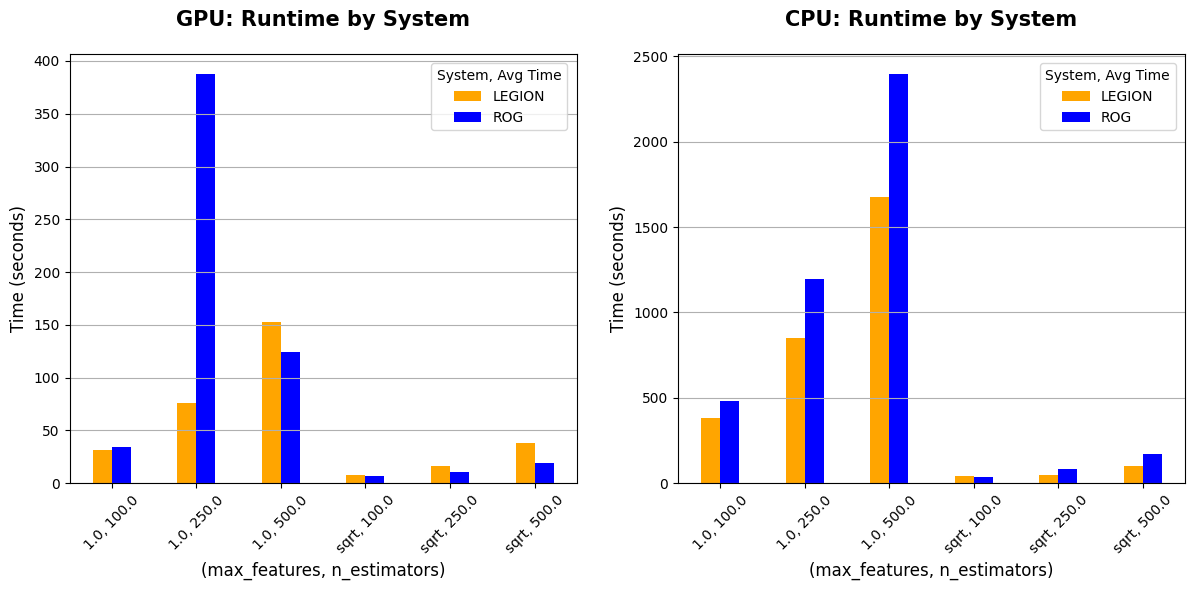

In [10]:
plot_runtime_by_system(
    unified_results, 
    ['max_features', 'n_estimators']
)

## Plot Runtime by Device
The following plot will compare the same system across different devices and combinations of features.
<br>
The function will plot 1 additional system automatically, right beside LEGION and ROG. 
<br>
To plot more than 3 systems, you'd need to modify the code.
<br>
<br>
Additionally, please feel free to pass a different feature combination into the function, for example:
<br>
```
plot_runtime_by_device(
    unified_results, 
    ['n_features', 'n_estimators']
)
```

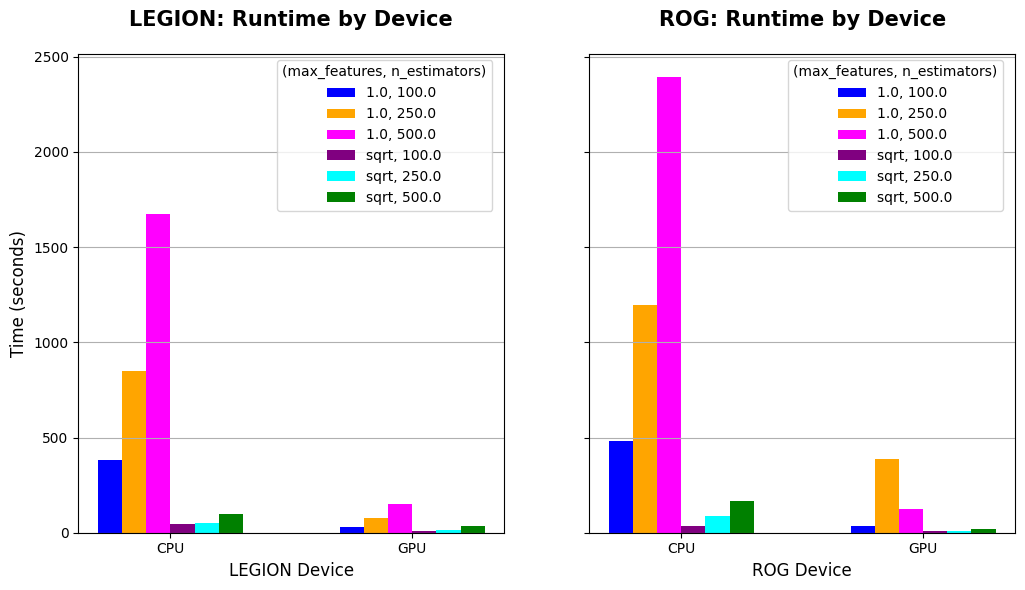

In [11]:
plot_runtime_by_device(
    unified_results, 
    ['max_features', 'n_estimators']
)

## Expanded Plot Runtime By System
The following function is an expanded version of the above `plot_runtime_by_system` function.
<br>
Instead of plotting combinations of two variables, the function below plots combinations of all 3 variables:
<br>
`['max_features', 'n_estimators', 'n_features']`

In [14]:
def expanded_plot_runtime_by_system(data, device):
    """
    compare the performance of a triplet of features over distinct systems:
    ['max_features', 'n_estimators', 'n_features']
    
    (works for 2 or 3 systems with no code adjustments)
    """
    device_df = data[data['device'] == device].copy()
    
    # create labels for x-axis feature combinations
    device_df['combo_label'] = device_df.apply(
        lambda x: f"{int(x['n_features'])} {int(x['n_estimators'])} {x['max_features']}", 
        axis=1
    )
    # store unique labels for ticks
    combo_labels = device_df[
        device_df['system'] == device_df['system'].unique()[0]
    ]['combo_label'].unique()

    # sort systems
    systems = []
    for sys in device_df['system'].unique():
        # prepare data for plotting
        systems.append(
            device_df[device_df['system'] == sys].sort_values(
                ['n_features', 'n_estimators', 'max_features']
            )
        )
        
    # create bar chart
    plt.figure(figsize=(14, 6))
    x = range(len(combo_labels))
    
    # determine number of systems and set bar width
    num_systems = len(systems)
    # wider bars for 2 systems, narrower for 3
    bar_width = 0.35 if num_systems == 2 else 0.25  

    # plot bars based on number of systems
    plt.bar(x, systems[0]['time'], width=bar_width, label=systems[0]['system'].unique()[0], color='orange', align='center')
    plt.bar([i + bar_width for i in x], systems[1]['time'], width=bar_width, label=systems[1]['system'].unique()[0], color='blue', align='center')
    
    if num_systems == 3:
        plt.bar([i + 2 * bar_width for i in x], systems[2]['time'], width=bar_width, label=systems[2]['system'].unique()[0], color='magenta', align='center')
       
    # customize the plot
    plt.xlabel('Parameter Combination (n_features n_estimators max_features)', fontsize=12)
    plt.ylabel('Runtime (seconds)', fontsize=12)
    # dynamic title based on number of systems
    title = device + " Performance: " + " vs. ".join(sys['system'].unique()[0] for sys in systems)
    plt.title(title, fontsize=20, fontweight='bold', pad=20)
    plt.xticks([i + bar_width / 2 if num_systems == 2 else i + bar_width for i in x], combo_labels, rotation=45, ha='right')
    plt.legend(fontsize=15)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

### Expanded GPU Runtime
The following chart plots GPU performance across matching parameters on different systems.

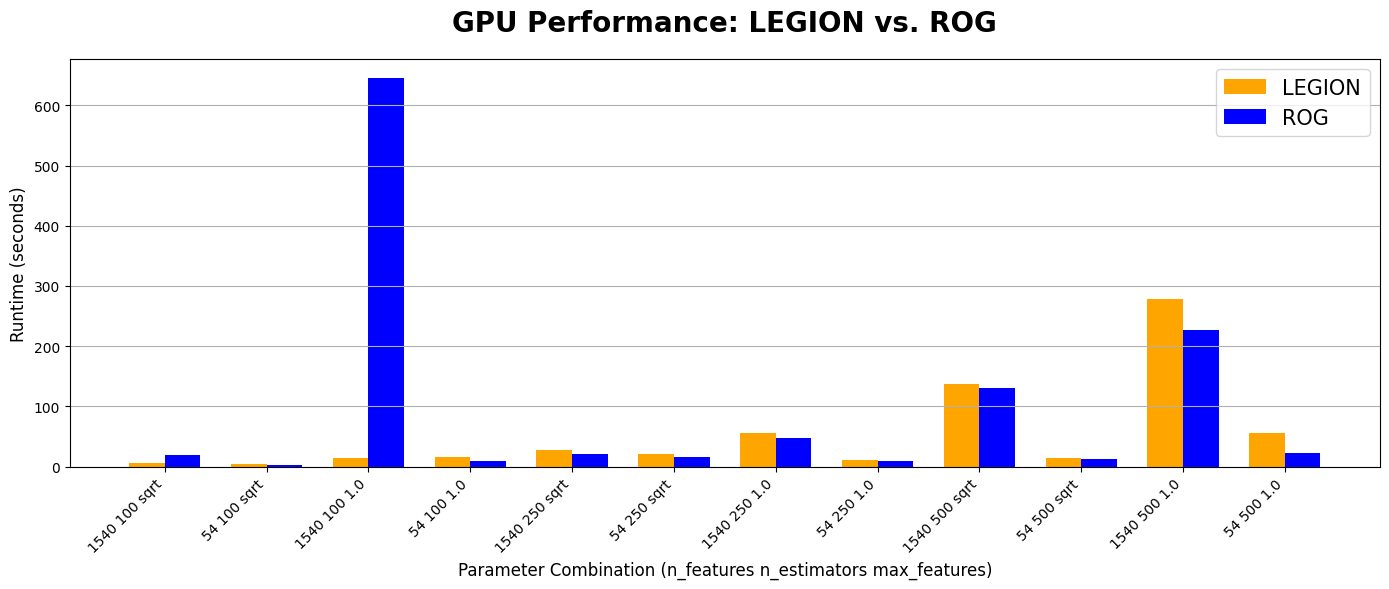

In [15]:
expanded_plot_runtime_by_system(unified_results, "GPU")

### Expanded CPU Runtime
The following chart plots CPU performance across matching parameters on different systems.

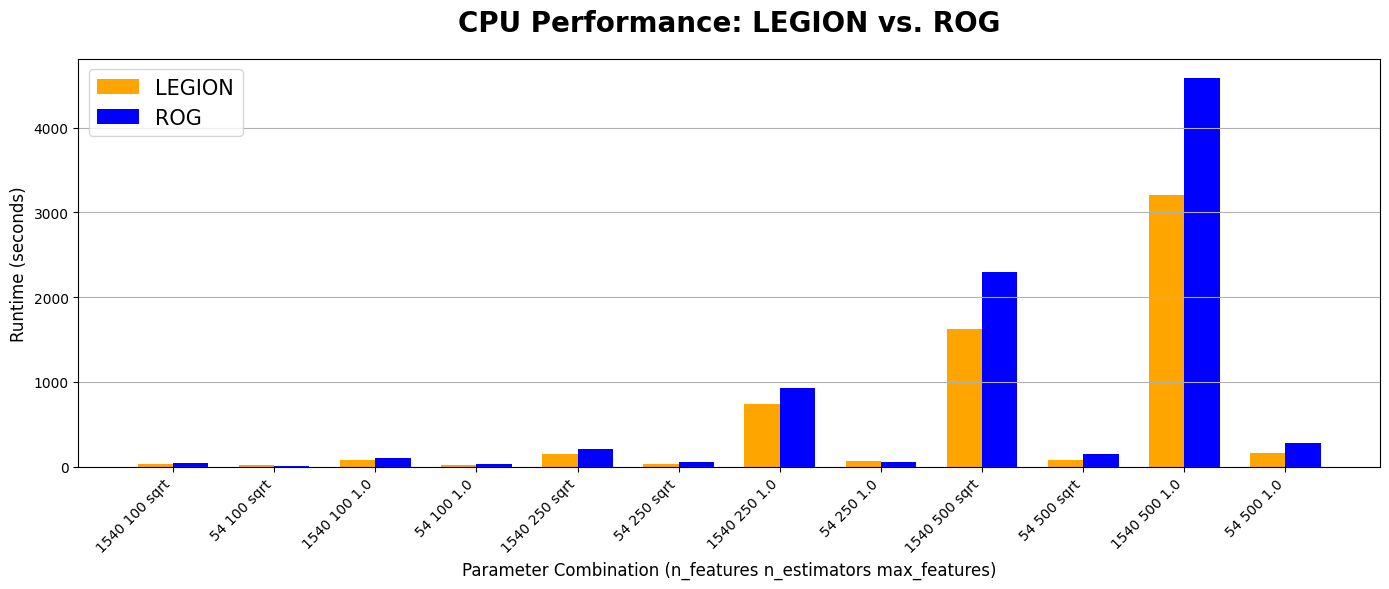

In [16]:
expanded_plot_runtime_by_system(unified_results, "CPU")

## Expanded Runtime by Device

The following function traces the GPU vs CPU performance gap for each triplet of variables on the same system:
<br>
`['max_features', 'n_estimators', 'n_features']`
<br>
<br>
It's an expanded version of the above `plot_runtime_by_device` function.

In [19]:
import numpy as np

def expanded_plot_runtime_by_device(data, system='LEGION', colors=['orange', 'magenta']):
    df_system = data[data['system'] == system].copy()
    devices = data['device'].unique()
    
    # Get unique n_features, n_estimators, max_features combinations for x-axis
    combos = df_system[
        ['n_features', 'n_estimators', 'max_features']
    ].drop_duplicates().sort_values(
        ['n_features', 'n_estimators', 'max_features']
    )
    combo_labels = [f"({int(n_f)}, {int(n_e)}, {m_f})" for n_f, n_e, m_f in combos.values]
    
    # aggregate time (mean) for each device and combination
    df_agg = df_system.groupby(
        ['device', 'n_features', 'n_estimators', 'max_features']
    )['time'].mean().reset_index()
    
    # create bar chart
    plt.figure(figsize=(12, 8)) 
    bar_width = 0.35
    x = np.arange(len(combos)) 

    # plot bars for CPU and GPU side by side for each combination
    for idx, dev in enumerate(devices):
        runtimes = []
        for n_f, n_e, m_f in combos.values:
            combo_data = df_agg[(df_agg['device'] == dev) & 
                               (df_agg['n_features'] == n_f) & 
                               (df_agg['n_estimators'] == n_e) & 
                               (df_agg['max_features'] == m_f)]
            runtime = combo_data['time'].values[0] if len(combo_data) > 0 else 0
            runtimes.append(runtime)
        # plot bars, offset by device index (CPU left, GPU right)
        plt.bar(x + idx * bar_width, runtimes, width=bar_width, label=dev, 
                color=colors[idx], align='center', alpha=0.9)
    
    # plot settings
    plt.xlabel('Parameters (n_features, n_estimators, max_features)', fontsize=12)
    plt.ylabel('Runtime (seconds)', fontsize=12)
    plt.title(f'{system} Scikit-Learn Performance: CPU vs. GPU', fontsize=20, fontweight='bold', pad=20)
    plt.xticks(x + bar_width / 2, combo_labels, rotation=45, ha='right')
    plt.grid(True, axis='y', color='grey', linestyle='-', alpha=0.5) 
    plt.legend(title='Device', loc='upper left', bbox_to_anchor=(0.05, 0.9), fontsize=15)
    plt.tight_layout()
    plt.show()

### Legion CPU vs GPU Performance Gap
The following results were observed on the LEGION system

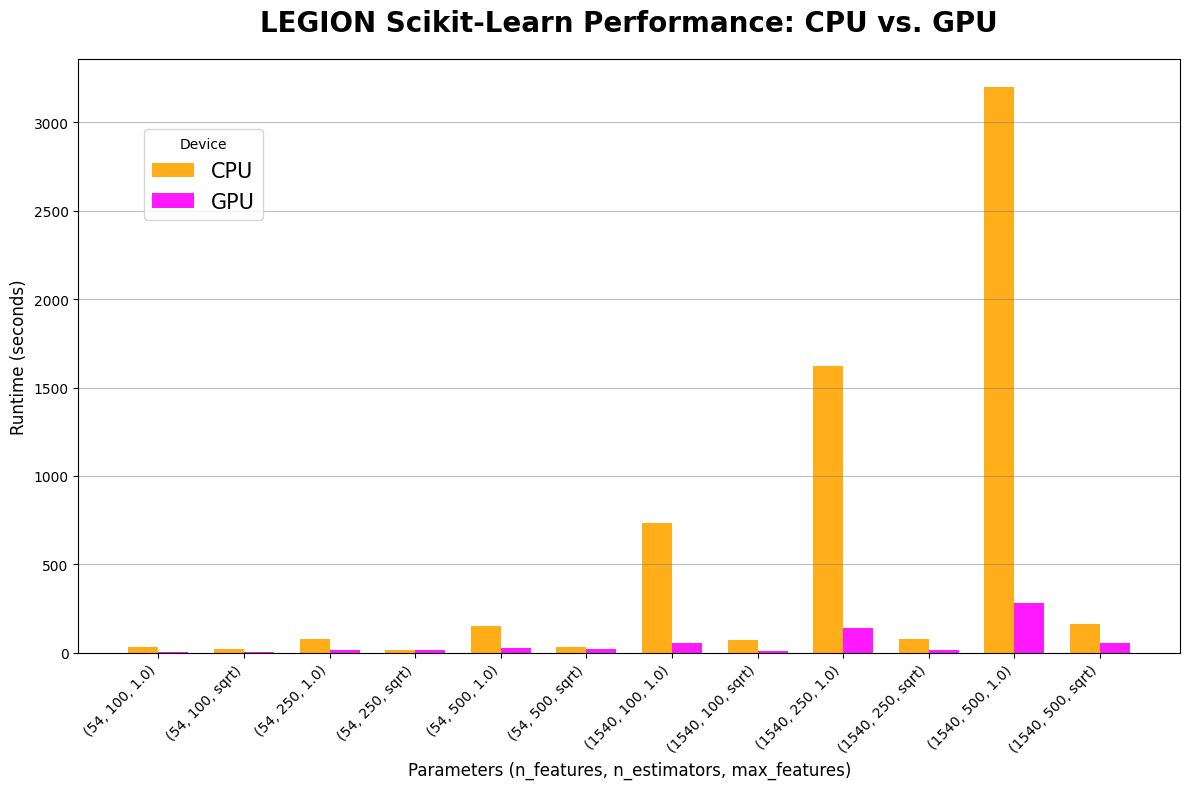

In [20]:
expanded_plot_runtime_by_device(unified_results, "LEGION")

### ROG CPU vs GPU Performance Gap
The following results were observed on the ROG system

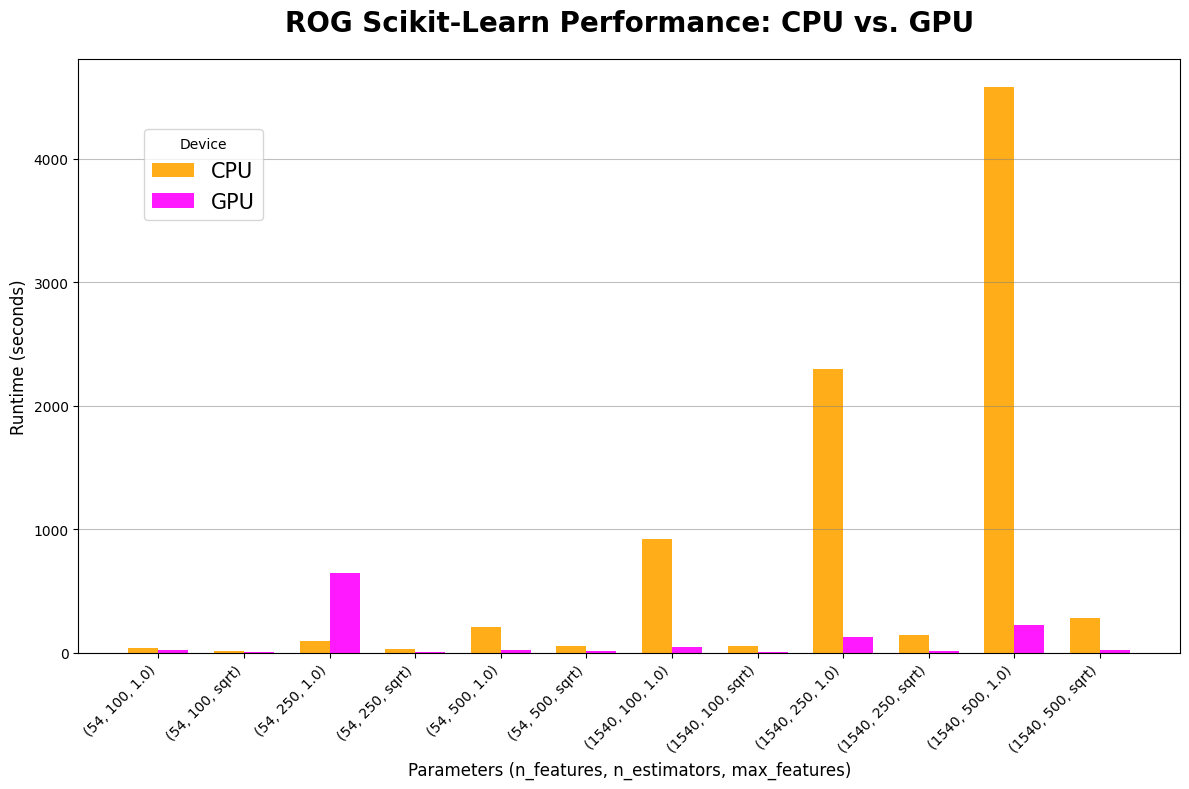

In [21]:
expanded_plot_runtime_by_device(unified_results, "ROG")